### What's going on
Here I perform an interesting experiment. I set down infront of my notebooke and started to randomly hit buttons on my keyboard. After I wrote long enough string, I apload it here and the set up GRU model to learn it to predict my random typing. In principle u can apload your own string (better not less then 10k simbols length) and rerun code to reproduce the results. 

### Model set up:
I encoded characters and also add embeddings layer as this set up performs much better then without embeddings. The model has easy tunable hidden size, number of hidden layers and embeddings dimension. 

### Learning features
I apply learning rate sheduler with patience level and minimul level to brake a plato. I also apply early stopping to stop learning when loss does not improve for sveral epoches in a row. I also left 10% of the set for test in the very end of the notebook. 

### Task set up and evaluation
I solve this problem as multiclassification task. I pass a sequence of characters to the model and predict next character. I use cross-entropy loss and to evaluation metrics: macro F1 score and weighter F1 score. Macro F1 is a simple average between binary F1 scores for each class and weighted F1 is weighted average where weights are chosen proportionaly to class imbalance in the data. 

In [98]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import collections
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import LambdaLR
from sklearn.metrics import f1_score

Here I upload a sequnce of characters that I completly randomly type on my keyboard by my hands

In [83]:
with open(r'C:\Users\310\Desktop\Progects_Py\data\studying-stuff_data\character_sequence_3.txt', 'r') as file:
    text = file.read()
    print(len(text))

10276


In [84]:
# Create a sorted list of unique characters in the text
chars = sorted(list(set(text)))
# Map each character to an index and create a reverse mapping
char_to_idx = {char: idx for idx, char in enumerate(chars)}
idx_to_char = {idx: char for idx, char in enumerate(chars)}

# Vocabulary size
vocab_size = len(chars)
print("Vocabulary Size:", vocab_size)

# Encode the entire text as a list of integer IDs
encoded_text = [char_to_idx[char] for char in text]

Vocabulary Size: 46


In [85]:
freq_count = {}
for char in char_to_idx:
    count = text.count(char)
    freq_count[char] = count

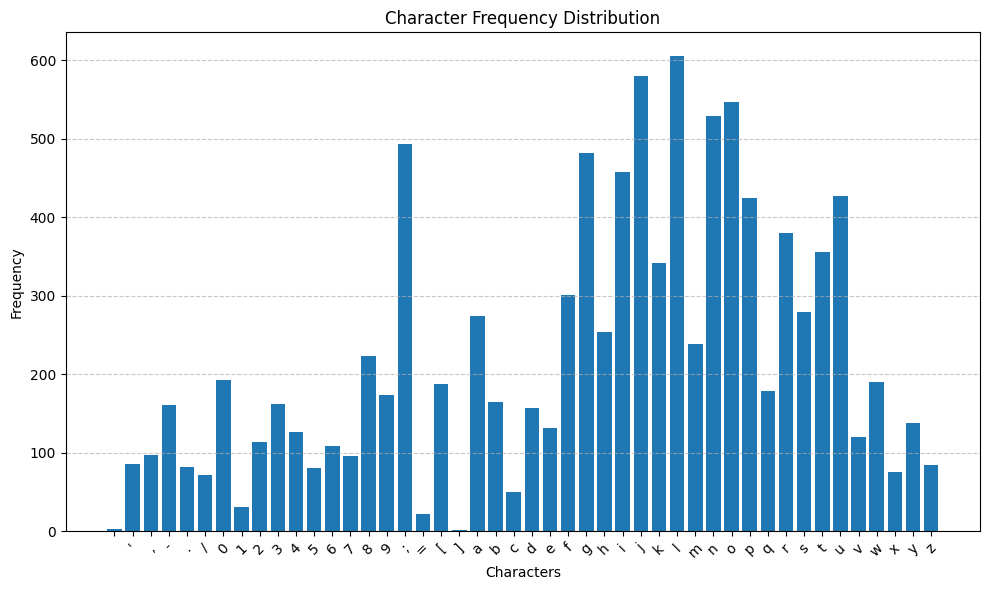

In [86]:
# Plotting
plt.figure(figsize=(10, 6))
plt.bar(freq_count.keys(), freq_count.values())
plt.xlabel('Characters')
plt.ylabel('Frequency')
plt.title('Character Frequency Distribution')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.tight_layout()
plt.show()

As we can see characters are heavily imbalaced which is natural. When u randomly hit the buttons on your keqboard u will hit buttond from the senter much more often

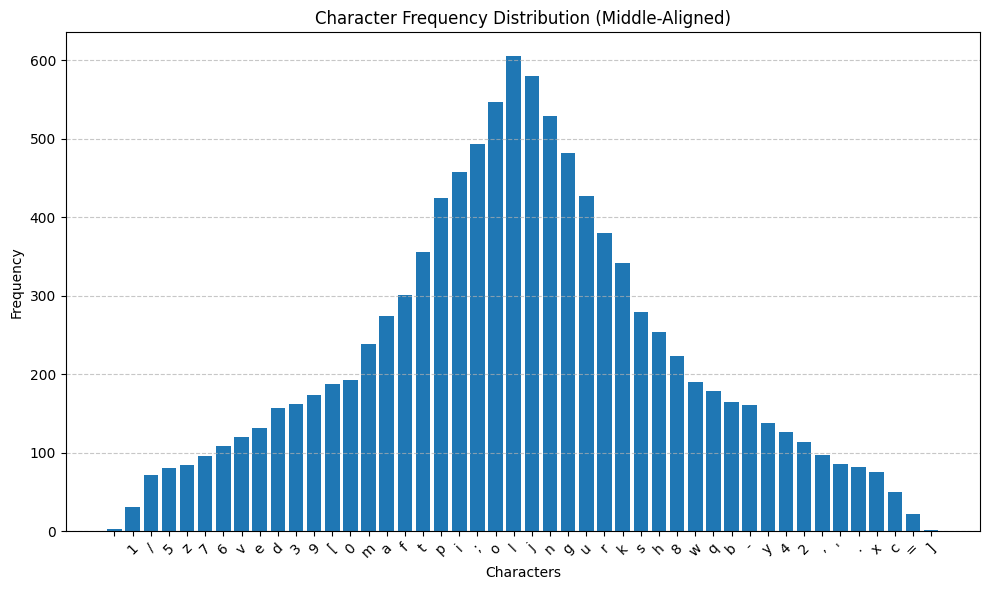

In [87]:
sorted_items = sorted(freq_count.items(), key=lambda item: item[1], reverse=True)

# Reorder for middle-aligned frequency distribution
middle_aligned = []
for i, item in enumerate(sorted_items):
    if i % 2 == 0:
        middle_aligned.insert(0, item)  # Insert at the beginning
    else:
        middle_aligned.append(item)     # Insert at the end

# Convert back to an ordered dictionary
middle_aligned_dict = collections.OrderedDict(middle_aligned)

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(middle_aligned_dict.keys(), middle_aligned_dict.values())
plt.xlabel('Characters')
plt.ylabel('Frequency')
plt.title('Character Frequency Distribution (Middle-Aligned)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.tight_layout()
plt.show()

Here we can clearly see that frequence decrease as character placed closer to the sid of the keyboard, conferming the randomness of typing.

In [88]:
test_ratio = 0.1
test_split_index = int(len(encoded_text) * (1 - test_ratio))

# Split the encoded text to get test sample
text = encoded_text[:test_split_index]
test_text = encoded_text[test_split_index:]

validation_ratio = 0.2
val_split_inde = int(len(text) * (1 - validation_ratio))

# Split the remaining text for validation and train samples
train_text = text[:val_split_inde]
valid_text = text[val_split_inde:]


In [92]:
#Train sequences
sequence_length = 70
batch_size = 50

# Training sequences and targets
train_sequences = []
train_targets = []

for i in range(len(train_text) - sequence_length):
    train_sequences.append(train_text[i:i + sequence_length])
    train_targets.append(train_text[i + sequence_length])

# Convert to tensors
X_train = torch.tensor(train_sequences, dtype=torch.long)
y_train = torch.tensor(train_targets, dtype=torch.long)

In [93]:
# Validation sequences
valid_sequences = []
valid_targets = []

for i in range(len(valid_text) - sequence_length):
    valid_sequences.append(valid_text[i:i + sequence_length])
    valid_targets.append(valid_text[i + sequence_length])

# Convert to tensors
X_valid = torch.tensor(valid_sequences, dtype=torch.long)
y_valid = torch.tensor(valid_targets, dtype=torch.long)

In [94]:
# Test sequences
test_sequences = []
test_targets = []

for i in range(len(test_text) - sequence_length):
    test_sequences.append(valid_text[i:i + sequence_length])
    test_targets.append(valid_text[i + sequence_length])

# Convert to tensors
X_test = torch.tensor(valid_sequences, dtype=torch.long)
y_test = torch.tensor(valid_targets, dtype=torch.long)

In [95]:

# Create TensorDatasets and DataLoaders
train_data = TensorDataset(X_train, y_train)
valid_data = TensorDataset(X_valid, y_valid)
test_data = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [96]:
# Define the GRU-based model WITH embeddings 
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout_rate=0.3):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout_rate = dropout_rate

        # Embedding layer to convert character indices into dense vectors
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # GRU layer
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate if num_layers > 1 else 0)

        # Dropout layer before the fully connected layer
        self.dropout = nn.Dropout(dropout_rate)
        
        # Fully connected layer for output
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Pass input through embedding layer to get (batch_size, sequence_length, embedding_dim)
        x = self.embedding(x)
        
        # Initialize hidden state with zeros: (num_layers, batch_size, hidden_size)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate GRU with embedded input
        out, _ = self.gru(x, h0)

        # Apply dropout to the GRU output before passing to the fully connected layer
        out = self.dropout(out)
        
        # Get the last time step's output for prediction
        out = self.fc(out[:, -1, :])
        
        return out
    
# Parametrs
embedding_dim = 70
hidden_size = 150
output_size = vocab_size  # Number of unique characters
num_layers = 2
dropout_rate = 0.1

# Initialize the model, loss function, and optimizer
model = GRUModel(input_size=embedding_dim, hidden_size=hidden_size, output_size=output_size, num_layers=num_layers, dropout_rate=dropout_rate)
criterion = nn.CrossEntropyLoss()  # Use CrossEntropyLoss for character prediction
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [60]:
# Define the GRU-based model WITHOUT embeddings 
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout_rate=0.3):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout_rate = dropout_rate

        # Embedding layer to convert character indices into dense vectors
        #self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # GRU layer
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate if num_layers > 1 else 0)

        # Dropout layer before the fully connected layer
        self.dropout = nn.Dropout(dropout_rate)
        
        # Fully connected layer for output
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Reshape input to have a single feature dimension (batch_size, sequence_length, 1)
        x = x.unsqueeze(-1).float()
        
        # Initialize hidden state with zeros: (num_layers, batch_size, hidden_size)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate GRU with embedded input
        out, _ = self.gru(x, h0)

        # Apply dropout to the GRU output before passing to the fully connected layer
        out = self.dropout(out)
        
        # Get the last time step's output for prediction
        out = self.fc(out[:, -1, :])
        
        return out
    
# Parametrs
embedding_dim = 1 # Must be 1, since we are directly use encoded characters
hidden_size = 128
output_size = vocab_size  # Number of unique characters
num_layers = 1
dropout_rate = 0

# Initialize the model, loss function, and optimizer
model = GRUModel(input_size=embedding_dim, hidden_size=hidden_size, output_size=output_size, num_layers=num_layers, dropout_rate=dropout_rate)
criterion = nn.CrossEntropyLoss()  # Use CrossEntropyLoss for character prediction
#optimizer = optim.Adam(model.parameters(), lr=0.0001)

It turns out that even tho we have charater level prediction task model set up with embeddings performs significantly better both in terms of learning speed and loss performance

In [ ]:
best_train_loss = float('inf')      # Best train loss across all epochs
best_valid_loss = float('inf')       # Best test loss across all epochs
best_mf1 = 0
best_wf1 = 0
#current_best_train_loss = float('inf')  # Best train loss for the current epoch

Epoch [10/150], Train Loss: 2.7854,              Validation Loss: 2.8751
   Overall Best Train Loss: 0.0068, Overall Best validation Loss: 2.6807
            Macro F1 Score: 0.1228,       Best Weighted F1 Score: 0.1378
Learning Rate: 0.0001
Epoch [20/150], Train Loss: 2.6418,              Validation Loss: 2.7873
   Overall Best Train Loss: 0.0068, Overall Best validation Loss: 2.6807
            Macro F1 Score: 0.1228,       Best Weighted F1 Score: 0.1485
Learning Rate: 0.0001
Epoch [30/150], Train Loss: 2.5252,              Validation Loss: 2.7807
   Overall Best Train Loss: 0.0068, Overall Best validation Loss: 2.6807
            Macro F1 Score: 0.1228,       Best Weighted F1 Score: 0.1590
Learning Rate: 0.0001
Epoch [40/150], Train Loss: 2.4181,              Validation Loss: 2.8021
   Overall Best Train Loss: 0.0068, Overall Best validation Loss: 2.6807
            Macro F1 Score: 0.1228,       Best Weighted F1 Score: 0.1660
Learning Rate: 0.0001
Epoch [50/150], Train Loss: 2.3320, 

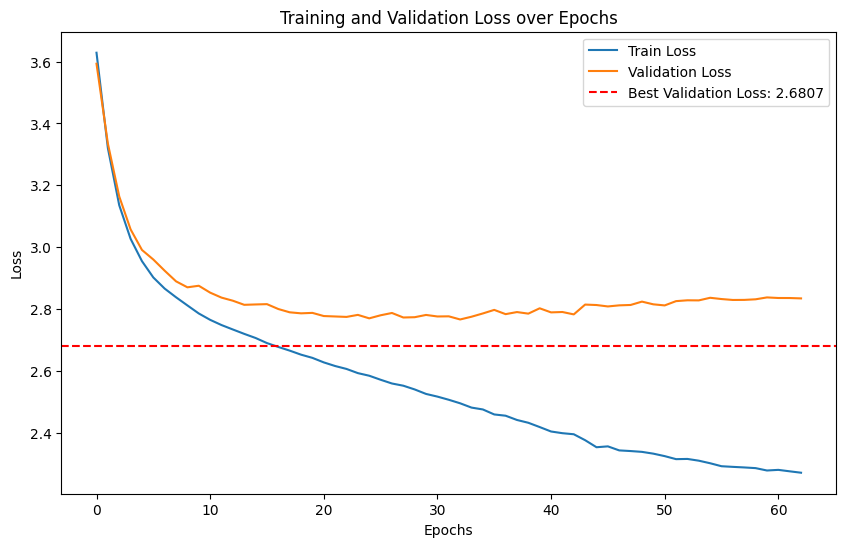

In [97]:
initial_lr = 0.0001
min_lr = 0.00001

# Set the optimizer and scheduler
optimizer = optim.Adam(model.parameters(), lr=initial_lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, min_lr=min_lr)


# Define early stopping parameters
early_stopping_patience = 30  # Number of epochs to wait for improvement
current_best_valid_loss = float('inf')   # Best test loss for the current epoch
no_improvement_epochs = 0  # Counter for epochs without improvement


num_epochs = 150

# Collect losses to plot learning dinamics
train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    epoch_train_loss = 0  # Accumulate training loss over batches for the current epoch
    
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        epoch_train_loss += loss.item()  # Accumulate loss
    
    # Calculate the average training loss for this epoch
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Update the overall best train loss across all epochs
    best_train_loss = min(best_train_loss, avg_train_loss)
    
    # Evaluation phase
    model.eval()
    valid_loss = 0
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for X_batch, y_batch in valid_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            valid_loss += loss.item()

            # Store predictions and targets for F1 calculation
            _, preds = torch.max(outputs, dim=1)
            all_targets.extend(y_batch.cpu().numpy())
            all_predictions.extend(preds.cpu().numpy())


    # Calculate the average test loss for this epoch
    avg_valid_loss = valid_loss / len(valid_loader)
    valid_losses.append(avg_valid_loss)

    # Step the scheduler with validation loss
    scheduler.step(avg_valid_loss)

    # Check for improvement
    if avg_valid_loss < current_best_valid_loss:
        no_improvement_epochs = 0  # Reset counter
    else:
        no_improvement_epochs += 1  # Increment counter if no improvement

    # Update the current best train loss for the session
    current_best_valid_loss = min(current_best_valid_loss, avg_valid_loss)
    
    # Update the overall best test loss across all epochs
    best_valid_loss = min(best_valid_loss, avg_valid_loss)

    # Calculate F1 scores
    macro_f1 = f1_score(all_targets, all_predictions, average='macro')
    weighted_f1 = f1_score(all_targets, all_predictions, average='weighted')

    best_mf1 = max(best_mf1, macro_f1)
    best_wf1 = max(best_wf1, weighted_f1)
    
    # Print loss every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f},              Validation Loss: {avg_valid_loss:.4f}")
        print(f"   Overall Best Train Loss: {best_train_loss:.4f}, Overall Best validation Loss: {best_valid_loss:.4f}")
        print(f"            Macro F1 Score: {best_mf1:.4f},       Best Weighted F1 Score: {best_wf1:.4f}")
        # Print current learning rate
        current_lr = scheduler.get_last_lr()[0]  # Get the current learning rate
        print(f"Learning Rate: {current_lr}")
    
    if no_improvement_epochs >= early_stopping_patience:
        print(f"Early stopping at epoch {epoch+1}, no improvement in validation loss for {early_stopping_patience} consecutive epochs.")
        break

# Plot train and validation losses with a horizontal line for the best validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')

# Add horizontal line at the best validation loss
plt.axhline(y=best_valid_loss, color='r', linestyle='--', label=f'Best Validation Loss: {best_valid_loss:.4f}')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [99]:
# Define the test function
def test_model(model, test_loader, criterion):
    model.eval()  # Set model to evaluation mode
    test_loss = 0
    all_targets = []
    all_predictions = []
    
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            test_loss += loss.item()
            
            # Store predictions and true labels for metrics calculation
            _, preds = torch.max(outputs, dim=1)
            all_targets.extend(y_batch.cpu().numpy())
            all_predictions.extend(preds.cpu().numpy())
    
    # Calculate average test loss
    avg_test_loss = test_loss / len(test_loader)
    
    # Calculate accuracy and F1 scores

    macro_f1 = f1_score(all_targets, all_predictions, average='macro')
    weighted_f1 = f1_score(all_targets, all_predictions, average='weighted')
    
    print(f"Test Loss: {avg_test_loss:.4f}")
    print(f"Test Macro F1 Score: {macro_f1:.4f}")
    print(f"Test Weighted F1 Score: {weighted_f1:.4f}")

# Call the test function after training
test_model(model, test_loader, criterion)

Test Loss: 2.8342
Test Macro F1 Score: 0.1151
Test Weighted F1 Score: 0.1699
